# Evaluation test 

Import all the header files needed to complete the required tasks.
1. `os` to get *.h5* file
2. `datetime` and `pytz` for task 1.
3. `h5py` and `csv` for task 2.
4. `np`, `scipy`, and `matplotlip` for task 3.  

In [78]:
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy import signal as sig
import numpy as np
import pytz
import h5py
import csv
import os

Function `set_name`looks for *.h5* in your folder and returns its name. Instead of this we could simply hardcode the filename too. 

In [79]:
def set_name():
    for file in os.listdir("."):
        if file.endswith(".h5"):
            return file

file = set_name()
print(file)

1541962108935000000_167_838.h5


In [51]:
#optional
file = "1541962108935000000_167_838.h5"

## Test 1

1. `time_unix_nano` is the actual 19 digit integer that we need to convert into a datetime object. 
2. `timezone_sec` is the required timezone for CERN.

In [80]:
time_unix_nano = int(file.split('.')[0].split('_')[0])
timezone_sec = pytz.timezone('Europe/Zurich')

print(time_unix_nano)

1541962108935000000


1. Documentation for [utcfromtimestamp](https://docs.python.org/3/library/datetime.html#datetime.datetime.utcfromtimestamp): Return the UTC datetime corresponding to the POSIX timestamp, with `tzinfo` None.
2. Hence to convert it into CERN timezone, we first replace `tzinfo` to `pytz.utc` and then use `astimezone` to manipulate the timezone. 


In [81]:
time_utc = datetime.utcfromtimestamp(time_unix_nano/1e9)
time_cern = time_utc.replace(tzinfo=pytz.utc).astimezone(timezone_sec)

print(time_utc, time_cern)

2018-11-11 18:48:28.935000 2018-11-11 19:48:28.935000+01:00


## Test 2

`visit_and_seg` returns groups (including subgroups) and datasets. This is done by first iterating and storing all the objects available in h5py file using `visit`. We then test each object to be an instance of either `h5py.Group` or `h5py.Dataset`.


In [82]:
def visit_and_seg(f, groups=[], datasets=[]):
    all_h5_objs = []
    f.visit(all_h5_objs.append)

    for obj in all_h5_objs:
        if isinstance(f[obj], h5py.Group):
            groups.append(obj)
        elif isinstance(f[obj], h5py.Dataset):
            datasets.append(obj)
        else:
            continue
    return groups, datasets

## Test 2 (continued) and Test 3

1. Now we read out *h5py* and *csv* file in read and write modes respectively. I've chosen three categories to make csv pretty simple - *Group*, *Subgroup* and *Dataset name*. 
2. Had encountering an error while storing datasets in np.arrays - `TypeError: No NumPy equivalent for TypeBitfieldID exists`, which seems to be a pretty common problem for such h5py files conversion. So, I'm using an `try and except` method as a workaround. Any alternate suggestion would be appreciated.
3. Dictionaries are used to write in CSV.
4. Hardcoding file names, and paths should be avoided, instead of passing strings directly we can use string variables to store dataset names. It is skipped here, since current use case is pretty much simple and straight forward. 

In [91]:
with h5py.File(file, mode="r") as f:
    with open('awake_csv.csv', mode='w') as cs:
        groups, datasets = visit_and_seg(f, groups=[], datasets=[])
        fieldnames = ['Group', 'Subgroup', 'Name', 'Shape', 'Type', 'Size']
        writer = csv.DictWriter(cs, fieldnames=fieldnames)
        writer.writeheader()
        all_h5_objs = []
        groups = list(f.items())
        subgroups, datasets = visit_and_seg(f)

        for dataset in datasets:
            data = f.get(dataset)
            group = dataset.split('/')[0]
            subgroup = '/'.join(dataset.split('/')[0:-1])
            name = dataset.split('/')[-1]
            shape = data.shape
            try:
                dtype = data.dtype
            except TypeError:
                dtype = "Bytefield"
            size = data.size
            writer.writerow({'Group': group, 'Subgroup': subgroup, 'Name': name,
                   'Shape': shape, 'Type': dtype, 'Size': size})
    data1 = f.get("AwakeEventData/XMPP-STREAK/StreakImage/streakImageData")
    height = f.get("AwakeEventData/XMPP-STREAK/StreakImage/streakImageHeight")[0]
    width = f.get("AwakeEventData/XMPP-STREAK/StreakImage/streakImageWidth")[0]
    data_filt = sig.medfilt(np.reshape(data1, (height, width)))
    cs.close()
f.close()

Aspect ratio and Interpolation arguments are used to displays an image without interpolating between pixels if the display resolution is not the same as the image resolution, with automatic selection of aspect ratio. 

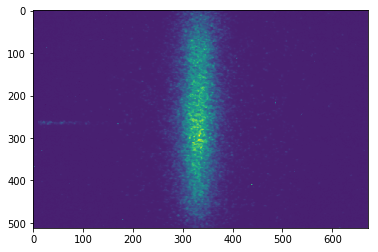

In [92]:
plt.imshow(data_filt, interpolation='nearest', aspect='auto')
plt.savefig('awakefig.png')
